In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
current = Path.cwd()
data_path = current.parent / 'data'

## Data extraction

In [5]:
original_df = pd.read_parquet(data_path / '01_interim' / 'daily_data_processed.parquet')

In [6]:
# Cyclical encoding
original_df['dayofweek_sin'] = np.sin(2 * np.pi * original_df['dayofweek'] / 7)
original_df['dayofweek_cos'] = np.cos(2 * np.pi * original_df['dayofweek'] / 7)
original_df['month_sin'] = np.sin(2 * np.pi * original_df['month'] / 12)
original_df['month_cos'] = np.cos(2 * np.pi * original_df['month'] / 12)
original_df['dayofyear_sin'] = np.sin(2 * np.pi * original_df['dayofyear'] / 365)
original_df['dayofyear_cos'] = np.cos(2 * np.pi * original_df['dayofyear'] / 365)
original_df['is_weekend'] = (original_df['Date'].dt.dayofweek >= 5).astype(int)

## First try with MLP

Total rows: 1677
Training rows: 1587
Test rows (30 × #ACORN): 90

Training MLP for ACORN = ACORN-C
  → Train size = 529, Test size = 30
  → Test RMSE = 1.1845, MAE = 0.8688, MAPE = 5.9019 %

Training MLP for ACORN = ACORN-F
  → Train size = 529, Test size = 30


c:\Users\alexj\Forecast-of-Electricity-Consumption\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning:

Training interrupted by user.



  → Test RMSE = 0.7020, MAE = 0.6098, MAPE = 5.7112 %

Training MLP for ACORN = ACORN-P
  → Train size = 529, Test size = 30
  → Test RMSE = 0.4505, MAE = 0.3792, MAPE = 5.2227 %



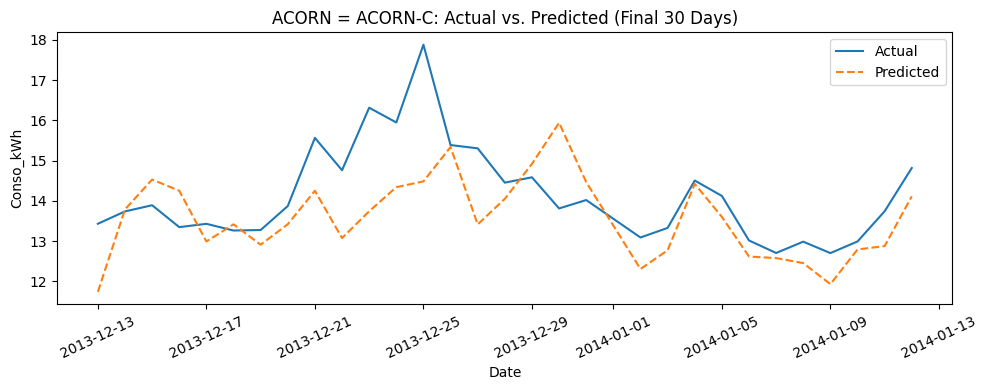

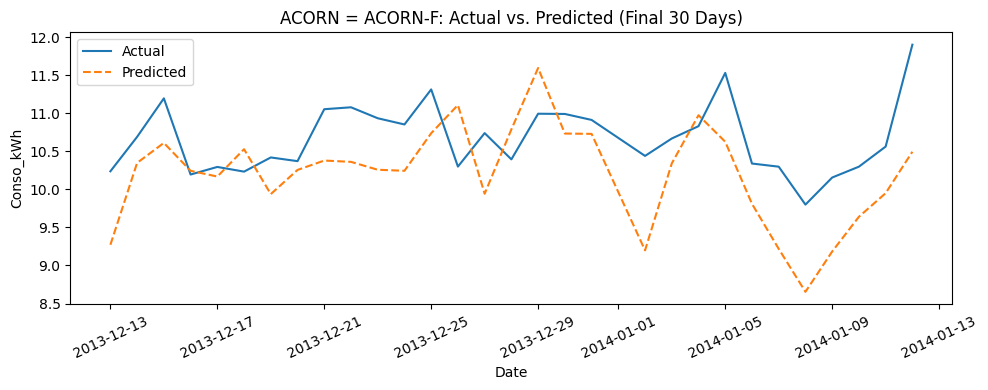

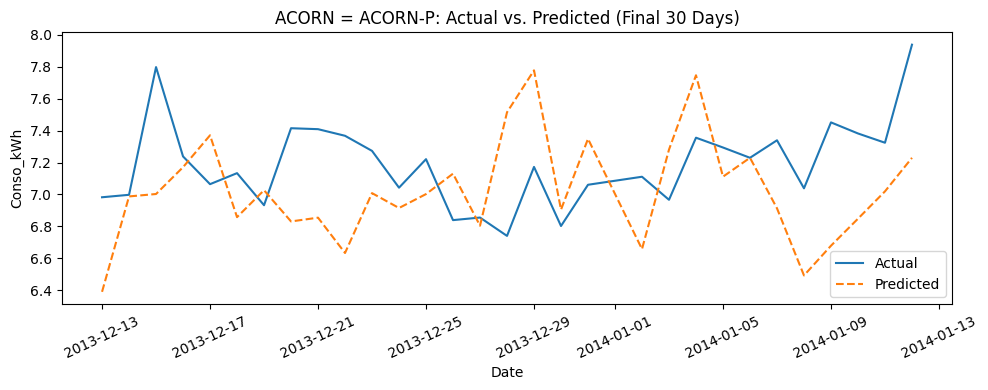

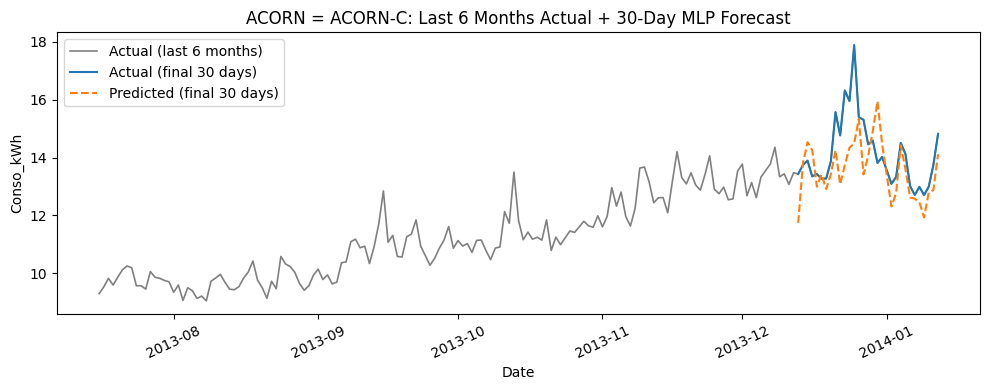

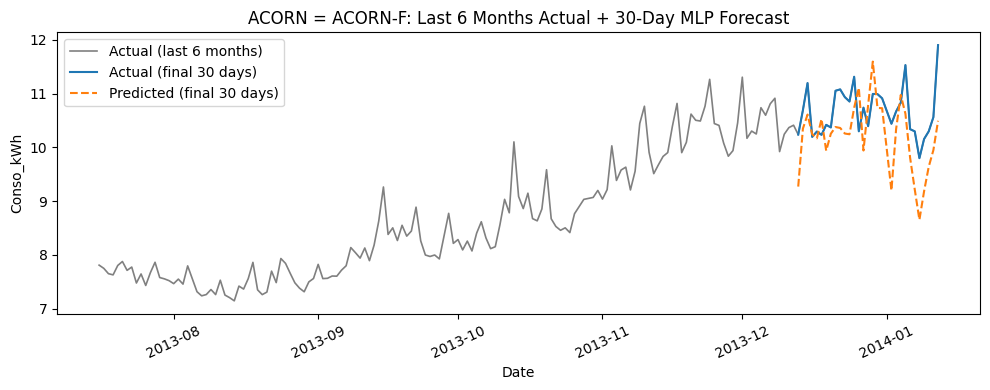

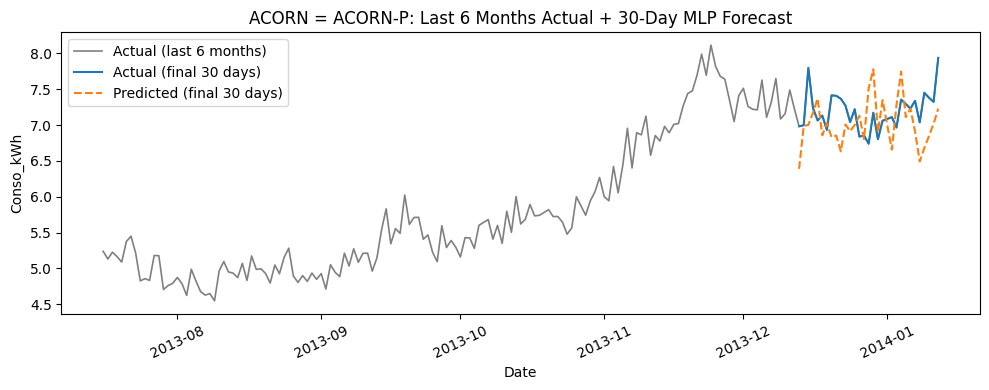

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# ──────────────────────────────────────────────────────────────────────────────
# ASSUMPTIONS:
#  • `df` is your DataFrame with columns exactly as shown:
#       ["temperatureMax","windBearing","icon","dewPoint","cloudCover",
#        "windSpeed","pressure","precipType","visibility","humidity",
#        "uvIndex","temperatureMin","moonPhase","Acorn","Date","nb_clients",
#        "Conso_kWh","is_holiday","dayofweek","month","dayofyear"]
#
#  • You want to hold out the final 30 days per ACORN as your test period and
#    train one MLP per ACORN on everything before those 30 days.
# ──────────────────────────────────────────────────────────────────────────────

# 1) SORT & ASSIGN GROUP INDEX (one row per day per ACORN)
df = original_df.copy()
df = df.sort_values(["Acorn", "Date"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# 2) MARK FINAL 30 DAYS (per ACORN) AS TEST
horizon = 30
group_sizes = df.groupby("Acorn")["group_idx"].max() + 1
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon),
    axis=1
)

# Split into train/test DataFrames
df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True ].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (30 × #ACORN): {len(df_test)}\n")

# 3) DEFINE FEATURE LISTS
categorical_features = ["windBearing", "icon", "precipType", "is_holiday", "is_weekend"]
numeric_features = ['temperatureMax','dewPoint', 'cloudCover', 'windSpeed', 'pressure',
 'visibility', 'humidity', 'uvIndex', 'temperatureMin', 'moonPhase',
 'dayofweek', 'month', 'dayofyear', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
 'month_cos', 'dayofyear_sin', 'dayofyear_cos']

# We will NOT include "Acorn" in features here since we train per-ACORN.
# 4) PREPARE A DICTIONARY TO HOLD RESULTS PER ACORN
results = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"Training MLP for ACORN = {acorn_label}")

    # 4.1) SUBSET THIS ACORN’S TRAIN / TEST
    train_sub = df_train[df_train["Acorn"] == acorn_label].reset_index(drop=True)
    test_sub  = df_test [df_test ["Acorn"] == acorn_label].reset_index(drop=True)

    # 4.2) EXTRACT X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = train_sub["Conso_kWh"].values
    y_test_sub  = test_sub ["Conso_kWh"].values

    drop_cols = ["Conso_kWh", "group_idx", "is_test", "Acorn", "Date"]
    X_train_sub = train_sub.drop(columns=drop_cols)
    X_test_sub  = test_sub .drop(columns=drop_cols)

    print(f"  → Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")

    # 4.3) BUILD COLUMNTRANSFORMER FOR THIS ACORN
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )

    # 4.4) BUILD PIPELINE: PREPROCESSOR → MLPREGRESSOR
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        max_iter=500,
        random_state=42
    )

    pipe = Pipeline([
        ("preproc", preprocessor),
        ("mlp", mlp)
    ])

    # 4.5) FIT ON THE TRAINING SUBSET FOR THIS ACORN
    pipe.fit(X_train_sub, y_train_sub)

    # 4.6) PREDICT ON THE TEST SUBSET (FINAL 30 DAYS)
    y_pred_sub = pipe.predict(X_test_sub)

    # 4.7) COMPUTE RMSE / MAE
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %\n")

    # 4.8) STORE RESULTS
    test_sub = test_sub.copy()
    test_sub["Predicted_kWh"] = y_pred_sub

    results[acorn_label] = {
        "pipeline":    pipe,
        "df_train_sub": train_sub,
        "df_test_sub":  test_sub,
        "y_test_sub":  y_test_sub,
        "y_pred_sub":  y_pred_sub
    }

# ──────────────────────────────────────────────────────────────────────────────
# 5) PLOT 1: ACTUAL vs. PREDICTED ON TEST PERIOD (30 DAYS) – ONE FIGURE PER ACORN
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results.items():
    test_sub = info["df_test_sub"].sort_values("Date")

    plt.figure(figsize=(10, 4))
    plt.plot(
        test_sub["Date"],
        test_sub["Conso_kWh"],
        label="Actual",
        linewidth=1.5
    )
    plt.plot(
        test_sub["Date"],
        test_sub["Predicted_kWh"],
        linestyle="--",
        label="Predicted",
        linewidth=1.5
    )
    plt.xlabel("Date")
    plt.ylabel("Conso_kWh")
    plt.title(f"ACORN = {acorn_label}: Actual vs. Predicted (Final 30 Days)")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 6) PLOT 2: LAST 6 MONTHS OF REAL DATA + FINAL 30-DAY PREDICTION (ONE FIGURE PER ACORN)
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results.items():
    train_sub = info["df_train_sub"]
    test_sub  = info["df_test_sub"]

    # 6.1) FULL ACORN HISTORY
    full_sub = pd.concat([train_sub, test_sub], ignore_index=True).sort_values("Date")

    # 6.2) DETERMINE LAST DATE AND 6-MONTHS AGO
    last_date = full_sub["Date"].max()
    six_months_ago = last_date - pd.Timedelta(days=180)

    # 6.3) FILTER TO LAST 6 MONTHS OF ACTUAL (includes final 30 days)
    hist_6m = full_sub[full_sub["Date"] >= six_months_ago].copy().reset_index(drop=True)

    plt.figure(figsize=(10, 4))
    # 6.4) Plot actual last 6 months (solid gray)
    plt.plot(
        hist_6m["Date"],
        hist_6m["Conso_kWh"],
        color="gray",
        linewidth=1.2,
        label="Actual (last 6 months)"
    )
    # 6.5) Overlay final 30 days actual in blue
    plt.plot(
        test_sub["Date"],
        test_sub["Conso_kWh"],
        color="C0",
        linewidth=1.5,
        label="Actual (final 30 days)"
    )
    # 6.6) Overlay final 30 days predicted in dashed orange
    plt.plot(
        test_sub["Date"],
        test_sub["Predicted_kWh"],
        color="C1",
        linestyle="--",
        linewidth=1.5,
        label="Predicted (final 30 days)"
    )

    plt.xlabel("Date")
    plt.ylabel("Conso_kWh")
    plt.title(f"ACORN = {acorn_label}: Last 6 Months Actual + 30-Day MLP Forecast")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()



## Hyperparameter tuning for MLP

In [7]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import plotly as po
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# ──────────────────────────────────────────────────────────────────────────────
# ASSUMPTIONS:
#  • You have a DataFrame `df` with columns:
#       ["temperatureMax", "windBearing", "icon", "dewPoint", "cloudCover",
#        "windSpeed", "pressure", "precipType", "visibility", "humidity",
#        "uvIndex", "temperatureMin", "moonPhase", "Acorn", "Date",
#        "nb_clients", "Conso_kWh", "is_holiday", "dayofweek", "month", "dayofyear"]
#  • You wish to train one MLP per ACORN, holding out the final 30 days per ACORN
#    as a test set, and use Optuna to tune hyperparameters on each ACORN’s training data.
# ──────────────────────────────────────────────────────────────────────────────

# 1) SORT & ASSIGN GROUP INDEX
df = original_df.copy()
df = df.sort_values(["Acorn", "Date"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# 2) MARK FINAL 30 DAYS (per ACORN) AS TEST
horizon_days = 30
group_sizes = df.groupby("Acorn")["group_idx"].max() + 1
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon_days),
    axis=1
)

df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True ].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows ({horizon_days} × #ACORN): {len(df_test)}\n")

# 3) DEFINE FEATURE LISTS (per‐ACORN: exclude "Acorn")
categorical_features = ["windBearing", "icon", "precipType", "is_holiday", "is_weekend"]
numeric_features = ['temperatureMax','dewPoint', 'cloudCover', 'windSpeed', 'pressure',
 'visibility', 'humidity', 'uvIndex', 'temperatureMin', 'moonPhase',
 'dayofweek', 'month', 'dayofyear', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
 'month_cos', 'dayofyear_sin', 'dayofyear_cos']

# 4) DICTIONARY TO STORE RESULTS
results = {}

# 5) LOOP OVER EACH ACORN FOR OPTUNA TUNING + FINAL TRAIN & EVALUATION
for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== TUNING & TRAINING MLP FOR ACORN = {acorn_label} ===")
    
    # 5.1) SUBSET THIS ACORN’S TRAIN/TEST
    train_sub = df_train[df_train["Acorn"] == acorn_label].reset_index(drop=True)
    test_sub  = df_test [df_test ["Acorn"] == acorn_label].reset_index(drop=True)
    
    # 5.2) EXTRACT X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = train_sub["Conso_kWh"].astype(float).values
    y_test_sub  = test_sub ["Conso_kWh"].astype(float).values
    
    drop_cols = ["Conso_kWh", "group_idx", "is_test", "Acorn", "Date"]
    X_train_sub = train_sub.drop(columns=drop_cols)
    X_test_sub  = test_sub .drop(columns=drop_cols)
    
    print(f"  → Train size = {X_train_sub.shape[0]}, Test size = {X_test_sub.shape[0]}")
    
    # 5.3) BUILD A PREPROCESSOR (per‐ACORN)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # 5.4) DEFINE OPTUNA OBJECTIVE FOR MLP
    def objective(trial):
        # Architecture: choose 1 to 3 hidden layers
        n_layers = trial.suggest_int("n_layers", 1, 3)
        layers = []
        for i in range(n_layers):
            # size of each layer: 32 to 256
            layer_size = trial.suggest_categorical(f"layer_{i}", [32, 64, 128, 256])
            layers.append(layer_size)
        hidden_layer_sizes = tuple(layers)
        
        # Regularization (L2 penalty)
        alpha = trial.suggest_loguniform("alpha", 1e-6, 1e-2)
        
        # Learning rate init
        learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-5, 1e-2)
        
        # Learning rate schedule
        learning_rate = trial.suggest_categorical("learning_rate", ["constant", "adaptive"])
        
        # Activation function
        activation = trial.suggest_categorical("activation", ["relu", "tanh"])
        
        # Solver
        solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
        
        # Batch size (only relevant for 'adam'; ignored for 'lbfgs')
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        
        # Tolerance for stopping
        tol = trial.suggest_loguniform("tol", 1e-5, 1e-3)
        
        # Build the MLPRegressor with these hyperparameters
        mlp = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            batch_size=batch_size,
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            tol=tol,
            max_iter=500,
            random_state=42
        )
        
        # Build the pipeline
        pipe = Pipeline([
            ("preproc", preprocessor),
            ("mlp", mlp)
        ])
        
        # TimeSeriesSplit CV on this ACORN’s training subset
        tscv = TimeSeriesSplit(n_splits=3)
        neg_rmse = cross_val_score(
            pipe,
            X_train_sub,
            y_train_sub,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        rmse_scores = -neg_rmse
        return float(rmse_scores.mean())
    
    # 5.5) RUN OPTUNA STUDY FOR THIS ACORN
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, n_jobs=6)
    
    best_params = study.best_params
    print(f"  → Best params: {best_params}")
    print(f"  → Best CV‐RMSE = {study.best_value:.4f}")
    
    # 5.6) REBUILD THE MLP PIPELINE WITH BEST HYPERPARAMETERS
    #    Extract hyperparameters
    best_layers = tuple(
        best_params[f"layer_{i}"] for i in range(best_params["n_layers"])
    )
    best_alpha = best_params["alpha"]
    best_lr_init = best_params["learning_rate_init"]
    best_lr = best_params["learning_rate"]
    best_activation = best_params["activation"]
    best_solver = best_params["solver"]
    best_batch = best_params["batch_size"]
    best_tol = best_params["tol"]
    
    best_mlp = MLPRegressor(
        hidden_layer_sizes=best_layers,
        activation=best_activation,
        solver=best_solver,
        alpha=best_alpha,
        batch_size=best_batch,
        learning_rate=best_lr,
        learning_rate_init=best_lr_init,
        tol=best_tol,
        max_iter=500,
        random_state=42
    )
    best_pipe = Pipeline([
        ("preproc", preprocessor),
        ("mlp", best_mlp)
    ])
    
    # 5.7) FIT BEST PIPELINE ON FULL TRAIN SUBSET
    best_pipe.fit(X_train_sub, y_train_sub)
    
    # 5.8) PREDICT ON TEST SUBSET
    y_pred_sub = best_pipe.predict(X_test_sub)
    
    # 5.9) COMPUTE TEST RMSE / MAE
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %\n")
    
    # 5.10) STORE RESULTS
    test_sub = test_sub.copy()
    test_sub["Predicted_kWh"] = y_pred_sub
    
    results[acorn_label] = {
        "best_params":   best_params,
        "cv_rmse":       study.best_value,
        "test_rmse":     rmse_sub,
        "test_mae":      mae_sub,
        "pipeline":      best_pipe,
        "df_train_sub":  train_sub,
        "df_test_sub":   test_sub,
        "y_test_sub":    y_test_sub,
        "y_pred_sub":    y_pred_sub
    }


c:\Users\alexj\Forecast-of-Electricity-Consumption\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-06 09:13:39,888] A new study created in memory with name: no-name-0499e9ce-6bb5-444f-b75f-8d14f8a287e5


Total rows: 1677
Training rows: 1587
Test rows (30 × #ACORN): 90


=== TUNING & TRAINING MLP FOR ACORN = ACORN-C ===
  → Train size = 529, Test size = 30


[I 2025-06-06 09:13:44,906] Trial 0 finished with value: 2.840073714719459 and parameters: {'n_layers': 2, 'layer_0': 32, 'layer_1': 128, 'alpha': 0.0013298603676312637, 'learning_rate_init': 0.006853742212475768, 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'adam', 'batch_size': 64, 'tol': 7.17684727896705e-05}. Best is trial 0 with value: 2.840073714719459.
[I 2025-06-06 09:13:54,649] Trial 3 finished with value: 0.8541382877588526 and parameters: {'n_layers': 2, 'layer_0': 256, 'layer_1': 128, 'alpha': 2.7193968388237863e-05, 'learning_rate_init': 0.00516180602287143, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'lbfgs', 'batch_size': 32, 'tol': 2.8453994643929167e-05}. Best is trial 3 with value: 0.8541382877588526.
[I 2025-06-06 09:13:55,941] Trial 5 finished with value: 4.028258346017872 and parameters: {'n_layers': 2, 'layer_0': 128, 'layer_1': 64, 'alpha': 0.00051174192419784, 'learning_rate_init': 2.7934966277506696e-05, 'learning_rate': 'consta

  → Best params: {'n_layers': 3, 'layer_0': 128, 'layer_1': 32, 'layer_2': 32, 'alpha': 1.6085891865248916e-06, 'learning_rate_init': 0.00026729969423089014, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'lbfgs', 'batch_size': 128, 'tol': 0.00018212017304994864}
  → Best CV‐RMSE = 0.7411


[I 2025-06-06 09:16:07,462] A new study created in memory with name: no-name-93c73188-d4c4-4ccd-bedc-247f9847d1bb


  → Test RMSE = 1.1832, MAE = 0.8805, MAPE = 6.0004 %


=== TUNING & TRAINING MLP FOR ACORN = ACORN-F ===
  → Train size = 529, Test size = 30


[I 2025-06-06 09:16:10,258] Trial 1 finished with value: 0.46570538280295354 and parameters: {'n_layers': 2, 'layer_0': 128, 'layer_1': 32, 'alpha': 8.524015268199363e-05, 'learning_rate_init': 0.00010768824411268976, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'lbfgs', 'batch_size': 64, 'tol': 0.00013049983549643073}. Best is trial 1 with value: 0.46570538280295354.
[I 2025-06-06 09:16:11,620] Trial 5 finished with value: 0.7705531954956673 and parameters: {'n_layers': 3, 'layer_0': 32, 'layer_1': 128, 'layer_2': 32, 'alpha': 0.0037499665987160823, 'learning_rate_init': 0.0020778568116805647, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'adam', 'batch_size': 32, 'tol': 0.00024726995779133826}. Best is trial 1 with value: 0.46570538280295354.
[I 2025-06-06 09:16:14,463] Trial 4 finished with value: 0.7673927199523775 and parameters: {'n_layers': 3, 'layer_0': 256, 'layer_1': 32, 'layer_2': 64, 'alpha': 1.6479068192241408e-06, 'learning_rate_init': 0.000

  → Best params: {'n_layers': 2, 'layer_0': 128, 'layer_1': 32, 'alpha': 8.524015268199363e-05, 'learning_rate_init': 0.00010768824411268976, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'lbfgs', 'batch_size': 64, 'tol': 0.00013049983549643073}
  → Best CV‐RMSE = 0.4657


[I 2025-06-06 09:18:39,372] A new study created in memory with name: no-name-139c2843-a606-4145-8b37-8504c7259323


  → Test RMSE = 0.4424, MAE = 0.3556, MAPE = 3.3227 %


=== TUNING & TRAINING MLP FOR ACORN = ACORN-P ===
  → Train size = 529, Test size = 30


[I 2025-06-06 09:18:39,909] Trial 2 finished with value: 0.9256103922037306 and parameters: {'n_layers': 2, 'layer_0': 32, 'layer_1': 32, 'alpha': 0.00022821725007698607, 'learning_rate_init': 0.001344904946179769, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'adam', 'batch_size': 128, 'tol': 0.0004073512319947207}. Best is trial 2 with value: 0.9256103922037306.
[I 2025-06-06 09:18:40,862] Trial 1 finished with value: 1.2061831952362059 and parameters: {'n_layers': 1, 'layer_0': 32, 'alpha': 0.0038808487076286606, 'learning_rate_init': 0.0010883292912428374, 'learning_rate': 'constant', 'activation': 'relu', 'solver': 'adam', 'batch_size': 128, 'tol': 0.00015174421413863978}. Best is trial 2 with value: 0.9256103922037306.
[I 2025-06-06 09:18:41,642] Trial 6 finished with value: 0.652532121265296 and parameters: {'n_layers': 1, 'layer_0': 128, 'alpha': 1.60617804785979e-06, 'learning_rate_init': 0.008451107087338015, 'learning_rate': 'constant', 'activation': 'relu', '

  → Best params: {'n_layers': 3, 'layer_0': 64, 'layer_1': 128, 'layer_2': 256, 'alpha': 0.0076133977775709885, 'learning_rate_init': 9.047427117744777e-05, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'lbfgs', 'batch_size': 128, 'tol': 0.0007482482386662401}
  → Best CV‐RMSE = 0.5734
  → Test RMSE = 0.6807, MAE = 0.5238, MAPE = 7.3021 %



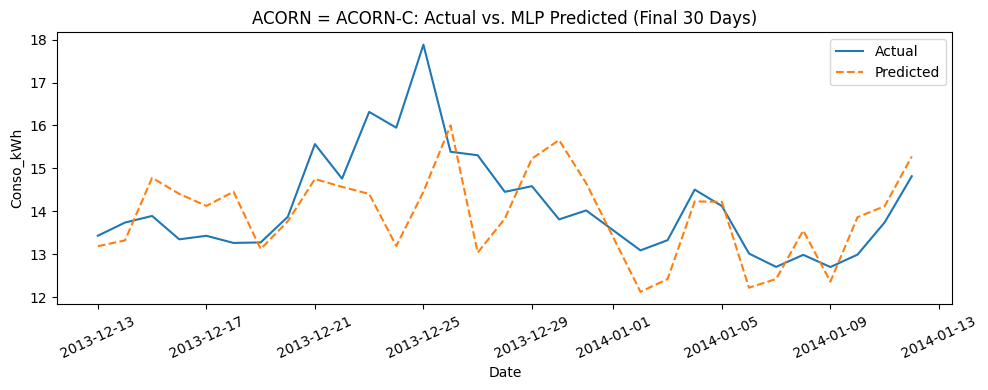

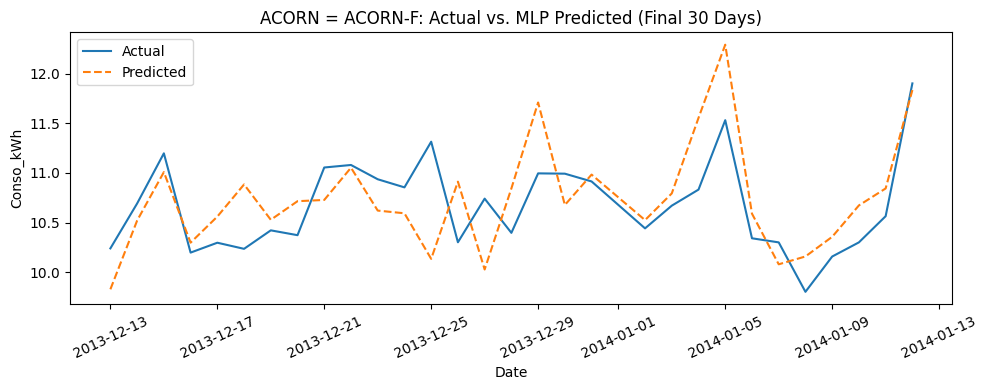

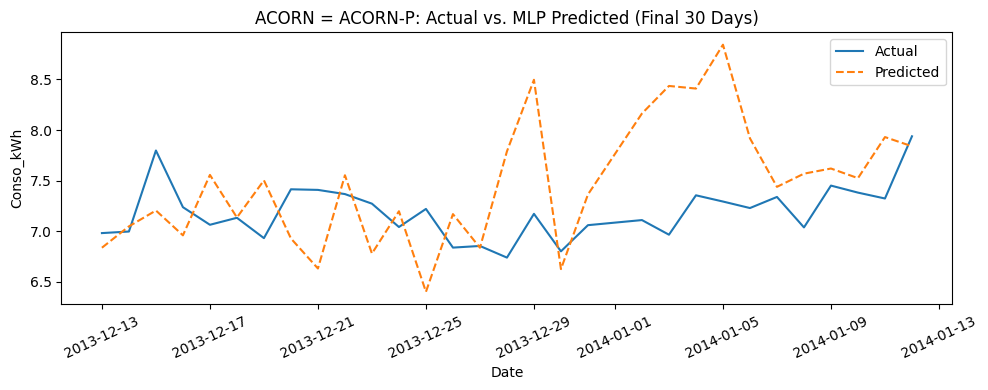

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) OPTIONAL: PLOTTING TEST RESULTS PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results.items():
    test_sub = info["df_test_sub"].sort_values("Date")
    plt.figure(figsize=(10, 4))
    plt.plot(
        test_sub["Date"],
        test_sub["Conso_kWh"],
        label="Actual",
        linewidth=1.5
    )
    plt.plot(
        test_sub["Date"],
        test_sub["Predicted_kWh"],
        linestyle="--",
        label="Predicted",
        linewidth=1.5
    )
    plt.xlabel("Date")
    plt.ylabel("Conso_kWh")
    plt.title(f"ACORN = {acorn_label}: Actual vs. MLP Predicted (Final 30 Days)")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

## Ahead prediction with MLP

In [109]:
pred_cons = pd.read_parquet(r'..\data\02_processed\parquet\group_4_daily_predict.parquet')
weather_daily = pd.read_parquet(r'..\data\01_interim\weather_daily_darksky_cleaned.parquet')

In [110]:
weather_daily = weather_daily.reset_index()
weather_daily.time = pd.to_datetime(weather_daily.time.dt.date)

In [111]:
weather_daily = weather_daily.drop(
    columns=[
        'apparentTemperatureHigh','temperatureHigh',
        'apparentTemperatureLow','temperatureLow',
        'apparentTemperatureMax','apparentTemperatureMin'
    ]
)

In [112]:
# Cyclical 
def create_features(weather_df, consumption_df):
    df = pd.merge(weather_df, consumption_df, left_on='time', right_on='Date').drop(columns='time').reset_index(drop=True)
    df["dayofweek"] = df["Date"].dt.dayofweek
    df["month"]     = df["Date"].dt.month
    df["dayofyear"] = df["Date"].dt.dayofyear
    holidays = pd.read_csv(r'..\data\00_raw\uk_bank_holidays.csv')
    holidays = pd.to_datetime(holidays['Bank holidays'])
    df['is_holiday'] = df['Date'].dt.date.isin(holidays.dt.date)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['is_weekend'] = (df['Date'].dt.dayofweek >= 5).astype(int)

    return df

In [113]:
pred_df = create_features(weather_daily, pred_cons)

In [114]:
for acorn_label in pred_cons.Acorn.unique():
    pred_acorn = pred_df[pred_df.Acorn == acorn_label].sort_values(by='Date').drop(columns='Date')
    pred_acorn = pred_acorn.drop(columns=['Acorn', 'Conso_kWh_predict'])
    indexes = pred_cons[pred_cons.Acorn == acorn_label].index
    pred_cons.loc[indexes, 'Conso_kWh_predict'] = results[acorn_label]['pipeline'].predict(pred_acorn)

In [115]:
pred_cons.to_parquet(r'..\data\02_processed\parquet\group_4_daily_predict_mlp.parquet', index=False)

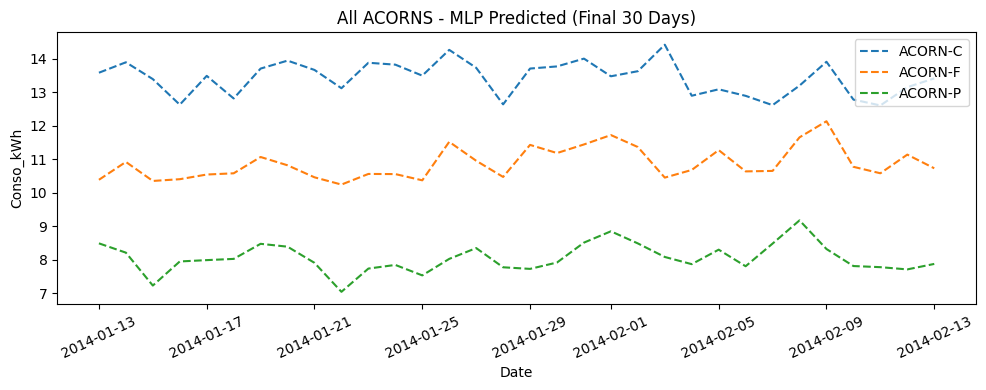

In [116]:
plt.figure(figsize=(10, 4))
for acorn_label, info in results.items():
    plt.plot(
        pred_cons[pred_cons.Acorn == acorn_label]["Date"],
        pred_cons[pred_cons.Acorn == acorn_label]["Conso_kWh_predict"],
        linestyle="--",
        label=acorn_label,
        linewidth=1.5
    )
plt.xlabel("Date")
plt.ylabel("Conso_kWh")
plt.title(f"All ACORNS - MLP Predicted (Final 30 Days)")
plt.legend()
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

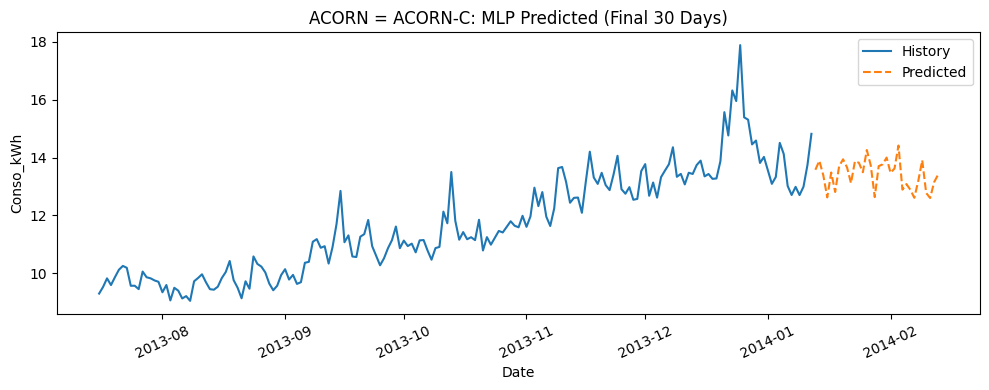

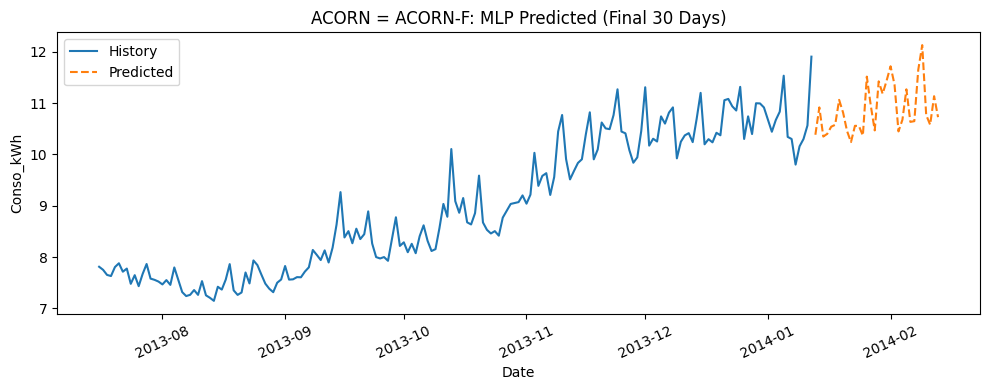

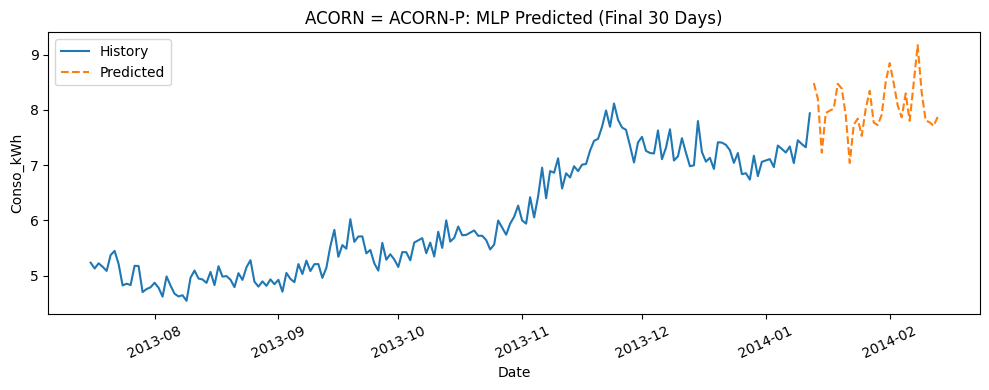

In [105]:
for acorn_label, info in results.items():
    plt.figure(figsize=(10, 4))
    df_last_6m = original_df[original_df['Acorn'] == acorn_label].sort_values(by='Date')
    df_last_6m = df_last_6m[df_last_6m['Date'] >= (df_last_6m['Date'].max() - pd.Timedelta(days=180))]
    plt.plot(df_last_6m["Date"],
             df_last_6m["Conso_kWh"],
             label="History")
    plt.plot(
        pred_cons[pred_cons.Acorn == acorn_label]["Date"],
        pred_cons[pred_cons.Acorn == acorn_label]["Conso_kWh_predict"],
        linestyle="--",
        label="Predicted",
        linewidth=1.5
    )
    plt.xlabel("Date")
    plt.ylabel("Conso_kWh")
    plt.title(f"ACORN = {acorn_label}: MLP Predicted (Final 30 Days)")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

## First try with SVM

Total rows: 1677
Training rows: 1587
Test rows (30 × #ACORN): 90

Training SVR for ACORN = ACORN-C
  → Train size = 529, Test size = 30
  → Test RMSE = 1.3425, MAE = 0.7752, MAPE = 5.0201 %

Training SVR for ACORN = ACORN-F
  → Train size = 529, Test size = 30
  → Test RMSE = 0.5439, MAE = 0.3990, MAPE = 3.6514 %

Training SVR for ACORN = ACORN-P
  → Train size = 529, Test size = 30
  → Test RMSE = 0.3369, MAE = 0.2668, MAPE = 3.6921 %



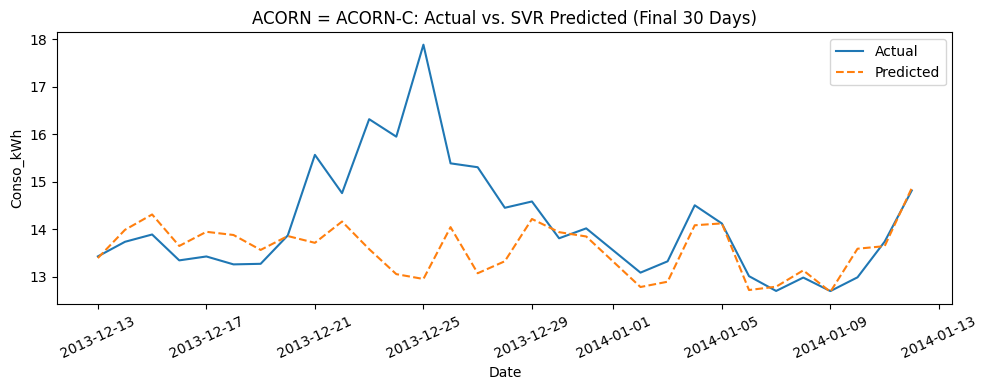

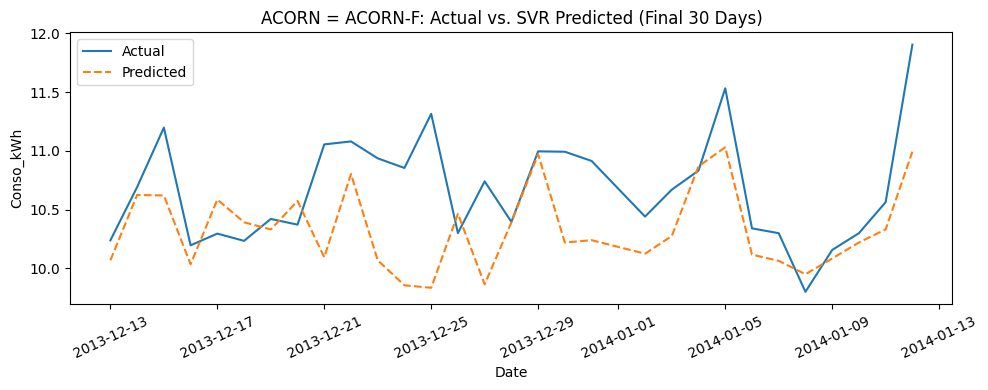

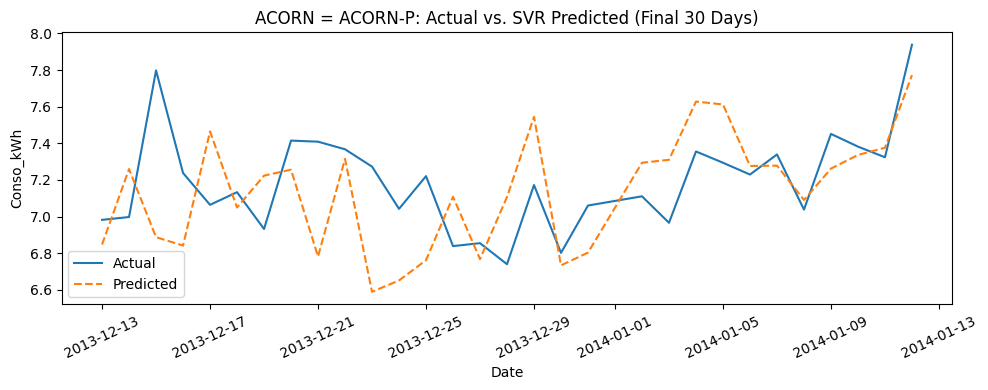

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# ASSUMPTIONS:
#  • `df` is the DataFrame with columns:
#       ["temperatureMax","windBearing","icon","dewPoint","cloudCover",
#        "windSpeed","pressure","precipType","visibility","humidity",
#        "uvIndex","temperatureMin","moonPhase","Acorn","Date","nb_clients",
#        "Conso_kWh","is_holiday","dayofweek","month","dayofyear"]
#  • We will hold out the final 30 days per ACORN as test and train one SVR per ACORN.
# ──────────────────────────────────────────────────────────────────────────────

# 1) SORT & ASSIGN GROUP INDEX
df = original_df.copy()
df = df.sort_values(["Acorn", "Date"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# 2) MARK FINAL 30 DAYS (per ACORN) AS TEST
horizon = 30
group_sizes = df.groupby("Acorn")["group_idx"].max() + 1
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon),
    axis=1
)

df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True ].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (30 × #ACORN): {len(df_test)}\n")

# 3) DEFINE FEATURE LISTS
categorical_features = ["windBearing", "icon", "precipType", "is_holiday", "is_weekend"]
numeric_features = ['temperatureMax','dewPoint', 'cloudCover', 'windSpeed', 'pressure',
 'visibility', 'humidity', 'uvIndex', 'temperatureMin', 'moonPhase',
 'dayofweek', 'month', 'dayofyear', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
 'month_cos', 'dayofyear_sin', 'dayofyear_cos']

results_svm = {}

# 4) LOOP OVER EACH ACORN TO TRAIN & EVALUATE SVR
for acorn_label in df_train["Acorn"].unique():
    print(f"Training SVR for ACORN = {acorn_label}")

    # 4.1) SUBSET THIS ACORN’S TRAIN/TEST
    train_sub = df_train[df_train["Acorn"] == acorn_label].reset_index(drop=True)
    test_sub  = df_test [df_test ["Acorn"] == acorn_label].reset_index(drop=True)

    # 4.2) EXTRACT X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = train_sub["Conso_kWh"].values
    y_test_sub  = test_sub ["Conso_kWh"].values

    drop_cols = ["Conso_kWh", "group_idx", "is_test", "Acorn", "Date"]
    X_train_sub = train_sub.drop(columns=drop_cols)
    X_test_sub  = test_sub .drop(columns=drop_cols)

    print(f"  → Train size = {X_train_sub.shape[0]}, Test size = {X_test_sub.shape[0]}")

    # 4.3) BUILD COLUMNTRANSFORMER FOR THIS ACORN
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )

    # 4.4) BUILD PIPELINE: PREPROCESSOR → SVR
    svr = SVR(kernel="rbf", C=1.0, epsilon=0.1)  # default hyperparameters
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("svr", svr)
    ])

    # 4.5) FIT ON TRAINING SUBSET
    pipe.fit(X_train_sub, y_train_sub)

    # 4.6) PREDICT ON TEST SUBSET
    y_pred_sub = pipe.predict(X_test_sub)

    # 4.7) COMPUTE RMSE / MAE
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %\n")

    # 4.8) STORE RESULTS
    test_sub = test_sub.copy()
    test_sub["Predicted_kWh"] = y_pred_sub

    results_svm[acorn_label] = {
        "pipeline":    pipe,
        "df_train_sub": train_sub,
        "df_test_sub":  test_sub,
        "y_test_sub":  y_test_sub,
        "y_pred_sub":  y_pred_sub
    }

# 5) PLOT: ACTUAL vs. PREDICTED ON TEST PERIOD (30 DAYS) – ONE FIGURE PER ACORN
for acorn_label, info in results_svm.items():
    test_sub = info["df_test_sub"].sort_values("Date")

    plt.figure(figsize=(10, 4))
    plt.plot(
        test_sub["Date"],
        test_sub["Conso_kWh"],
        label="Actual",
        linewidth=1.5
    )
    plt.plot(
        test_sub["Date"],
        test_sub["Predicted_kWh"],
        linestyle="--",
        label="Predicted",
        linewidth=1.5
    )
    plt.xlabel("Date")
    plt.ylabel("Conso_kWh")
    plt.title(f"ACORN = {acorn_label}: Actual vs. SVR Predicted (Final 30 Days)")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


## Hyperparameter tuning for SVM

Total rows:     1677
Training rows:  1587
Test rows (30 × #ACORN): 90


=== TUNING & TRAINING SVR FOR ACORN = ACORN-C ===
  → Train size = 529, Test size = 30
  → Best params: {'kernel': 'linear', 'C': 0.10724909638113007, 'epsilon': 0.08240570041047453}
  → Best CV‐RMSE = 0.9375
  → Test RMSE = 1.3633, MAE = 0.9194, MAPE = 6.0955 %


=== TUNING & TRAINING SVR FOR ACORN = ACORN-F ===
  → Train size = 529, Test size = 30
  → Best params: {'kernel': 'poly', 'C': 29.076870391772967, 'epsilon': 0.11159075589182983, 'gamma': 0.0035252248814585012, 'degree': 2, 'coef0': 1.0}
  → Best CV‐RMSE = 0.5394
  → Test RMSE = 0.3259, MAE = 0.2743, MAPE = 2.5698 %


=== TUNING & TRAINING SVR FOR ACORN = ACORN-P ===
  → Train size = 529, Test size = 30
  → Best params: {'kernel': 'rbf', 'C': 46.36761942065953, 'epsilon': 0.17617325440636183, 'gamma': 0.0012770293072737855}
  → Best CV‐RMSE = 0.5612
  → Test RMSE = 0.3573, MAE = 0.2924, MAPE = 4.0942 %



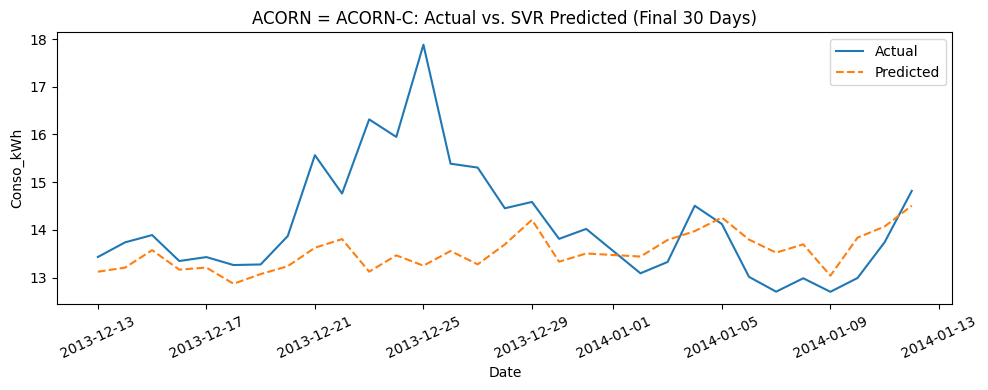

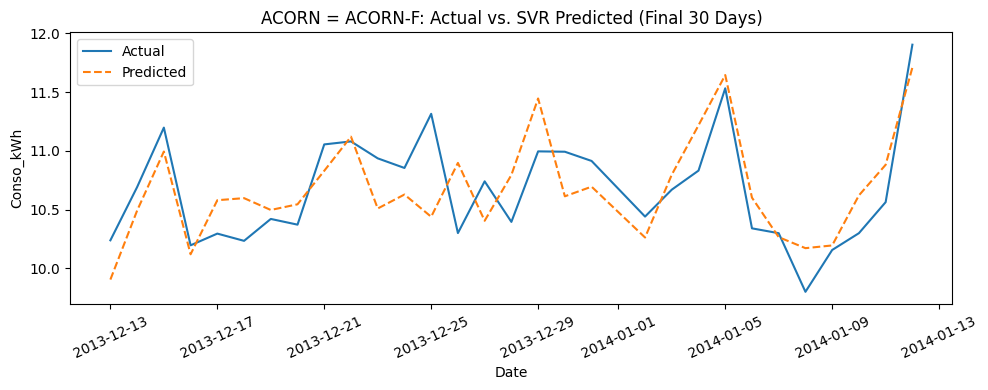

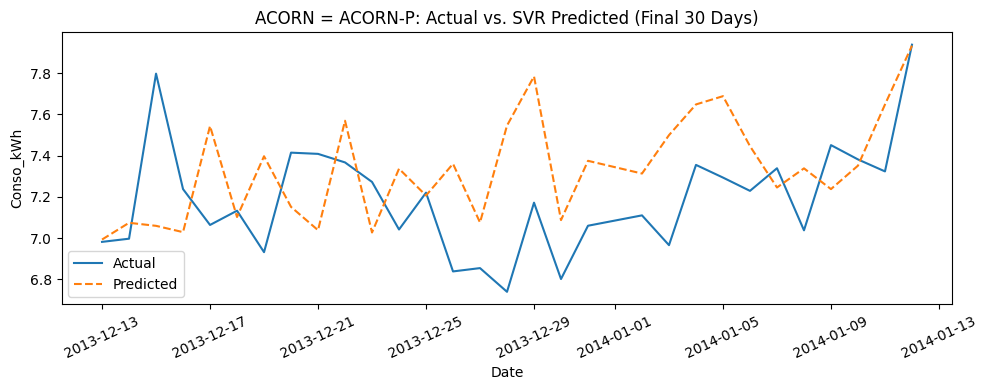

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# ──────────────────────────────────────────────────────────────────────────────
# 1) QUIET OPTUNA LOGS
# ──────────────────────────────────────────────────────────────────────────────
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ──────────────────────────────────────────────────────────────────────────────
# 2) ASSUME `df` ALREADY EXISTS WITH COLUMNS:
#      ["temperatureMax","windBearing","icon","dewPoint","cloudCover",
#       "windSpeed","pressure","precipType","visibility","humidity",
#       "uvIndex","temperatureMin","moonPhase","Acorn","Date","nb_clients",
#       "Conso_kWh","is_holiday","dayofweek","month","dayofyear"]
# ──────────────────────────────────────────────────────────────────────────────

# 2.1) SORT & ASSIGN WITHIN‐GROUP INDEX
df = original_df.copy()
df = df.sort_values(["Acorn", "Date"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# 2.2) MARK FINAL 30 DAYS (PER ACORN) AS TEST
horizon = 30
group_sizes = df.groupby("Acorn")["group_idx"].max() + 1
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon),
    axis=1
)

df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True ].copy()

print(f"Total rows:     {len(df)}")
print(f"Training rows:  {len(df_train)}")
print(f"Test rows (30 × #ACORN): {len(df_test)}\n")

# ──────────────────────────────────────────────────────────────────────────────
# 3) DEFINE FEATURE LISTS (PER‐ACORN: EXCLUDE "Acorn")
# ──────────────────────────────────────────────────────────────────────────────
categorical_features = ["windBearing", "icon", "precipType", "is_holiday", "is_weekend"]
numeric_features = ['temperatureMax','dewPoint', 'cloudCover', 'windSpeed', 'pressure',
 'visibility', 'humidity', 'uvIndex', 'temperatureMin', 'moonPhase',
 'dayofweek', 'month', 'dayofyear', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
 'month_cos', 'dayofyear_sin', 'dayofyear_cos']

# ──────────────────────────────────────────────────────────────────────────────
# 4) DICTIONARY TO STORE RESULTS
# ──────────────────────────────────────────────────────────────────────────────
results_svr = {}

# ──────────────────────────────────────────────────────────────────────────────
# 5) LOOP OVER EACH ACORN FOR OPTUNA TUNING + FINAL TRAIN & EVALUATION
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== TUNING & TRAINING SVR FOR ACORN = {acorn_label} ===")
    
    # 5.1) SUBSET THIS ACORN’S TRAIN / TEST
    train_sub = df_train[df_train["Acorn"] == acorn_label].reset_index(drop=True)
    test_sub  = df_test [df_test ["Acorn"] == acorn_label].reset_index(drop=True)
    
    # 5.2) EXTRACT X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = train_sub["Conso_kWh"].astype(float).values
    y_test_sub  = test_sub ["Conso_kWh"].astype(float).values
    
    drop_cols = ["Conso_kWh", "group_idx", "is_test", "Acorn", "Date"]
    X_train_sub = train_sub.drop(columns=drop_cols)
    X_test_sub  = test_sub .drop(columns=drop_cols)
    
    print(f"  → Train size = {X_train_sub.shape[0]}, Test size = {X_test_sub.shape[0]}")
    
    # 5.3) BUILD COLUMNTRANSFORMER FOR THIS ACORN
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # 5.4) DEFINE OPTUNA OBJECTIVE FOR SVR
    def objective(trial):
        # Kernel choice
        kernel = trial.suggest_categorical("kernel", ["rbf", "linear", "poly"])
        
        # Regularization parameter C
        C = trial.suggest_loguniform("C", 1e-2, 1e2)
        
        # Epsilon for ε-insensitive loss
        epsilon = trial.suggest_loguniform("epsilon", 1e-2, 1.0)
        
        # γ for RBF or polynomial; ignored for linear
        if kernel in ["rbf", "poly"]:
            gamma = trial.suggest_loguniform("gamma", 1e-4, 1.0)
        else:
            gamma = "auto"
        
        # Degree and coef0 for polynomial kernel
        if kernel == "poly":
            degree = trial.suggest_int("degree", 2, 4)
            coef0 = trial.suggest_categorical("coef0", [0.0, 0.1, 1.0])
        else:
            degree = 3  # default, unused for non-poly
            coef0 = 0.0
        
        svr = SVR(
            kernel=kernel,
            C=C,
            epsilon=epsilon,
            gamma=gamma,
            degree=degree,
            coef0=coef0
        )
        
        pipe = Pipeline([
            ("preproc", preprocessor),
            ("svr", svr)
        ])
        
        # TimeSeriesSplit CV on this ACORN’s training subset
        tscv = TimeSeriesSplit(n_splits=3)
        neg_rmse = cross_val_score(
            pipe,
            X_train_sub,
            y_train_sub,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        rmse_scores = -neg_rmse
        return float(rmse_scores.mean())
    
    # 5.5) RUN OPTUNA STUDY FOR THIS ACORN
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=80, show_progress_bar=False)
    
    best_params = study.best_params
    print(f"  → Best params: {best_params}")
    print(f"  → Best CV‐RMSE = {study.best_value:.4f}")
    
    # 5.6) REBUILD THE SVR PIPELINE WITH BEST HYPERPARAMETERS
    kernel_b = best_params["kernel"]
    C_b      = best_params["C"]
    epsilon_b= best_params["epsilon"]
    if kernel_b in ["rbf", "poly"]:
        gamma_b = best_params["gamma"]
    else:
        gamma_b = "auto"
    if kernel_b == "poly":
        degree_b = best_params["degree"]
        coef0_b  = best_params["coef0"]
    else:
        degree_b = 3
        coef0_b = 0.0
    
    best_svr = SVR(
        kernel=kernel_b,
        C=C_b,
        epsilon=epsilon_b,
        gamma=gamma_b,
        degree=degree_b,
        coef0=coef0_b
    )
    best_pipe = Pipeline([
        ("preproc", preprocessor),
        ("svr", best_svr)
    ])
    
    # 5.7) FIT BEST PIPELINE ON FULL TRAIN SUBSET
    best_pipe.fit(X_train_sub, y_train_sub)
    
    # 5.8) PREDICT ON TEST SUBSET
    y_pred_sub = best_pipe.predict(X_test_sub)
    
    # 5.9) COMPUTE TEST RMSE / MAE
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %\n")
    
    # 5.10) STORE RESULTS
    test_sub = test_sub.copy()
    test_sub["Predicted_kWh"] = y_pred_sub
    
    results_svr[acorn_label] = {
        "best_params":   best_params,
        "cv_rmse":       study.best_value,
        "test_rmse":     rmse_sub,
        "test_mae":      mae_sub,
        "pipeline":      best_pipe,
        "df_train_sub":  train_sub,
        "df_test_sub":   test_sub,
        "y_test_sub":    y_test_sub,
        "y_pred_sub":    y_pred_sub
    }

# ──────────────────────────────────────────────────────────────────────────────
# 6) OPTIONAL: PLOTTING TEST RESULTS PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_svr.items():
    test_sub = info["df_test_sub"].sort_values("Date")
    plt.figure(figsize=(10, 4))
    plt.plot(
        test_sub["Date"],
        test_sub["Conso_kWh"],
        label="Actual",
        linewidth=1.5
    )
    plt.plot(
        test_sub["Date"],
        test_sub["Predicted_kWh"],
        linestyle="--",
        label="Predicted",
        linewidth=1.5
    )
    plt.xlabel("Date")
    plt.ylabel("Conso_kWh")
    plt.title(f"ACORN = {acorn_label}: Actual vs. SVR Predicted (Final 30 Days)")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()
